### Colinearidade

O RDKit nos permite calcular 200 descritores 2D para descrever estruturas químicas. Alguns pacotes permitem o cálculo de ainda mais descritores. Dessa forma, é natural que alguns pares desses descritores sejam colineares. Isso quer dizer que, se fizermos um gráfico com os valores de um descritor no eixo x e de outro no eixo y, obteremos uma reta.

Como exemplo, vamos usar o banco de dados de Delaney e verificar a relação entre os descritores `MolWt` e `ExactMolWt` do RDKit, que correspondem à massa molecular relativa e massa molecular relativa exata, respectivamente.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [2]:
df = pd.read_csv("delaney-processed.csv")
df.head()

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


In [3]:
names = ["MolWt", "ExactMolWt"]
calc = MoleculeDescriptors.MolecularDescriptorCalculator(names)
descs = [calc.CalcDescriptors(Chem.MolFromSmiles(cpd)) for cpd in df["smiles"]]
descriptors_df = pd.DataFrame(descs, columns=names)
descriptors_df.head()

,MolWt,ExactMolWt
0,457.432,457.158411
1,201.225,201.078979
2,152.237,152.120115
3,278.354,278.109550
4,84.143,84.003371


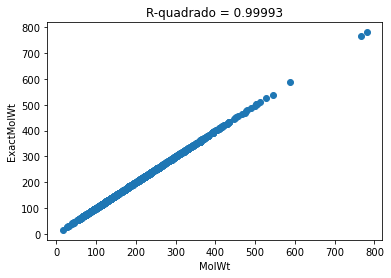

In [4]:
## Cálculo do coeficiente de correlação R²
r2 = str(r2_score(descriptors_df["MolWt"], descriptors_df["ExactMolWt"]).round(5))

## Gráfico
plt.scatter(descriptors_df["MolWt"], descriptors_df["ExactMolWt"])
plt.xlabel("MolWt")
plt.ylabel("ExactMolWt")
plt.title(f"R-quadrado = {r2}")
plt.show()

Vemos que esses dois descritores são praticamente idênticos. Isso é de se esperar, pois os valores diferem apenas nas casas decimais. 

Imagine agora que fôssemos treinar um modelo preditivo e que esses dois descritores estivessem presentes. Na melhor das hipóteses, nosso modelo usaria apenas um deles, e reconheceria o outro como sendo irrelevante. Porém, nem sempre isso ocorre, e existe a possibilidade de que a presença de variáveis correlacionadas introduza instabilidade aos modelos. Dessa forma, **é uma boa prática remover variáveis correlacionadas antes de criar modelos de ML**.

Uma forma de fazer isso é calculando a correlação entre todos os pares de variáveis. Vamos calcular mais alguns descritores para nosso conjunto de dados:

In [5]:
names = ["MolWt", "ExactMolWt", "FractionCSP3", "MolLogP", "NumAromaticRings", "NumHAcceptors", 
        "NumHDonors", "NumRotatableBonds", "TPSA", "LabuteASA"]
calc = MoleculeDescriptors.MolecularDescriptorCalculator(names)
descs = [calc.CalcDescriptors(Chem.MolFromSmiles(cpd)) for cpd in df["smiles"]]
descriptors_df = pd.DataFrame(descs, columns=names)
descriptors_df.head()

,MolWt,ExactMolWt,FractionCSP3,MolLogP,NumAromaticRings,NumHAcceptors,NumHDonors,NumRotatableBonds,TPSA,LabuteASA
0,457.432,457.158411,0.650000,-3.10802,1,12,7,7,202.32,182.935327
1,201.225,201.078979,0.083333,2.84032,2,2,1,2,42.24,87.724095
2,152.237,152.120115,0.500000,2.87800,0,1,0,4,17.07,68.806046
3,278.354,278.109550,0.000000,6.29940,5,0,0,0,0.00,128.158061
4,84.143,84.003371,0.000000,1.74810,1,1,0,0,0.00,35.071766


In [6]:
# Verificando a existência de variáveis altamente correlacionadas
from itertools import combinations

corr_matrix = descriptors_df.corr()
comb = combinations(corr_matrix.columns, 2)
for c1, c2 in comb:
    if abs(corr_matrix.loc[c1, c2]) > 0.8:
        print(f'r2 (módulo) entre as variáveis {c1} e {c2} = {corr_matrix.loc[c1, c2]:.3f}')

r2 (módulo) entre as variáveis MolWt e ExactMolWt = 1.000
r2 (módulo) entre as variáveis MolWt e LabuteASA = 0.970
r2 (módulo) entre as variáveis ExactMolWt e LabuteASA = 0.971
r2 (módulo) entre as variáveis NumHAcceptors e TPSA = 0.897


Verificamos que existem algumas variáveis altamente correlacionadas. Dessa forma, podemos remover `ExactMolWt` e `LabuteASA`, já que são colineares com `MolWt`, e `TPSA`, que é correlacionada com `NumHAcceptors`.

In [7]:
descriptors_df.drop(["ExactMolWt", "LabuteASA", "TPSA"], axis=1, inplace=True)
descriptors_df.head()

,MolWt,FractionCSP3,MolLogP,NumAromaticRings,NumHAcceptors,NumHDonors,NumRotatableBonds
0,457.432,0.650000,-3.10802,1,12,7,7
1,201.225,0.083333,2.84032,2,2,1,2
2,152.237,0.500000,2.87800,0,1,0,4
3,278.354,0.000000,6.29940,5,0,0,0
4,84.143,0.000000,1.74810,1,1,0,0


Com isso, nosso conjunto de dados está adequado para a criação de um modelo preditivo.